In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [6]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class ImprovedNet(nn.Module):
    def __init__(self, input_size=784, hidden_sizes=[128, 64, 32], num_classes=10, dropout_rate=0.3):
        super(ImprovedNet, self).__init__()
        
        # Build layers dynamically
        layers = []
        prev_size = input_size
        
        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            prev_size = hidden_size
        
        # Output layer (no dropout after final layer)
        layers.append(nn.Linear(prev_size, num_classes))
        
        self.network = nn.Sequential(*layers)
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')
                nn.init.constant_(module.bias, 0)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        return self.network(x)

class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1

        if self.counter >= self.patience:
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False

    def save_checkpoint(self, model):
        self.best_weights = model.state_dict().copy()

def load_and_preprocess_data(file_path):
    """Load and preprocess MNIST data"""
    try:
        with open(file_path, 'rb') as file:
            data = dict(pickle.load(file))
        
        X = data.get('X').astype(np.float32)
        y = data.get('y').reshape(-1).astype(np.int64)
        
        # Normalize pixel values to [0, 1]
        X = X / 255.0
        
        # Data augmentation function
        def add_noise(images, noise_factor=0.1):
            noise = np.random.normal(0, noise_factor, images.shape)
            return np.clip(images + noise, 0, 1)
        
        print(f"Data loaded: {X.shape[0]} samples, {X.shape[1]} features")
        print(f"Labels shape: {y.shape}")
        print(f"Unique classes: {np.unique(y)}")
        
        return X, y, add_noise
        
    except FileNotFoundError:
        print(f"Error: File {file_path} not found!")
        return None, None, None
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None, None

def create_data_loaders(X, y, train_ratio=0.8, val_ratio=0.1, batch_size=64, augment_data=False, add_noise_func=None):
    """Create train, validation, and test data loaders"""
    n_samples = len(X)
    n_train = int(train_ratio * n_samples)
    n_val = int(val_ratio * n_samples)
    
    # Split data
    indices = np.random.permutation(n_samples)
    train_idx = indices[:n_train]
    val_idx = indices[n_train:n_train + n_val]
    test_idx = indices[n_train + n_val:]
    
    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]
    X_test, y_test = X[test_idx], y[test_idx]
    
    # Data augmentation for training set
    if augment_data and add_noise_func is not None:
        X_train_aug = add_noise_func(X_train, noise_factor=0.05)
        X_train = np.concatenate([X_train, X_train_aug])
        y_train = np.concatenate([y_train, y_train])
        print(f"Data augmented: {X_train.shape[0]} training samples")
    
    # Convert to tensors and create datasets
    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train))
    val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val))
    test_dataset = TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test))
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
    
    return train_loader, val_loader, test_loader

def train_model(model, train_loader, val_loader, num_epochs=20, learning_rate=0.001):
    """Train the model with validation and early stopping"""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
    early_stopping = EarlyStopping(patience=7, min_delta=0.001)
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    model.to(device)
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += criterion(output, target).item()
                
                _, predicted = torch.max(output.data, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()
        
        # Calculate metrics
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print(f'LR: {optimizer.param_groups[0]["lr"]:.6f}')
        print('-' * 50)
        
        # Learning rate scheduling
        scheduler.step(avg_val_loss)
        
        # Early stopping
        if early_stopping(avg_val_loss, model):
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    return train_losses, val_losses, train_accuracies, val_accuracies

def evaluate_model(model, test_loader, class_names=None):
    """Comprehensive model evaluation"""
    model.eval()
    test_correct = 0
    test_total = 0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            
            test_total += target.size(0)
            test_correct += (predicted == target).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    test_accuracy = 100 * test_correct / test_total
    print(f'\nTest Accuracy: {test_accuracy:.2f}%')
    
    # Classification report
    if class_names is None:
        class_names = [str(i) for i in range(10)]
    
    print("\nClassification Report:")
    print(classification_report(all_targets, all_predictions, target_names=class_names))
    
    return test_accuracy, all_predictions, all_targets

def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot losses
    ax1.plot(train_losses, label='Training Loss', color='blue')
    ax1.plot(val_losses, label='Validation Loss', color='red')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracies
    ax2.plot(train_accuracies, label='Training Accuracy', color='blue')
    ax2.plot(val_accuracies, label='Validation Accuracy', color='red')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names=None):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

Using device: cpu


=== Improved MNIST Classification ===
Configuration: {'file_path': "D:\\wids '23\\Winter-Projects-of-Machine-Learning\\MNIST_data.pkl", 'batch_size': 64, 'num_epochs': 20, 'learning_rate': 0.001, 'hidden_sizes': [128, 64, 32], 'dropout_rate': 0.3, 'augment_data': True}
Data loaded: 60000 samples, 784 features
Labels shape: (60000,)
Unique classes: [0 1 2 3 4 5 6 7 8 9]
Data augmented: 96000 training samples
Train: 96000, Val: 6000, Test: 6000

Model architecture:
ImprovedNet(
  (network): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): BatchNorm1d(3

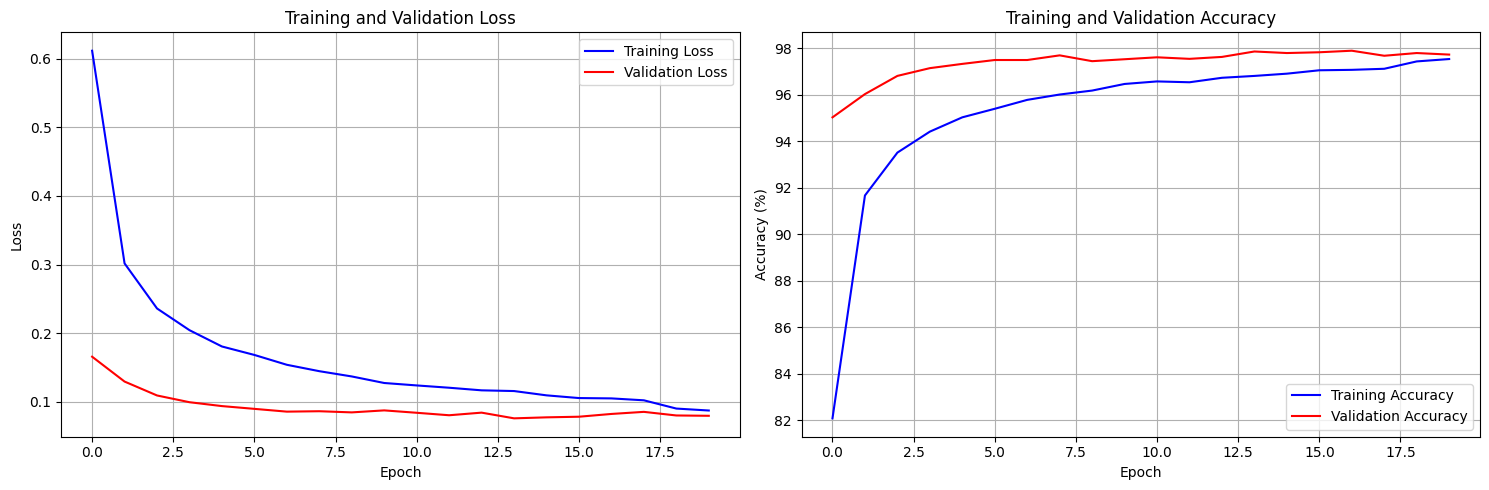

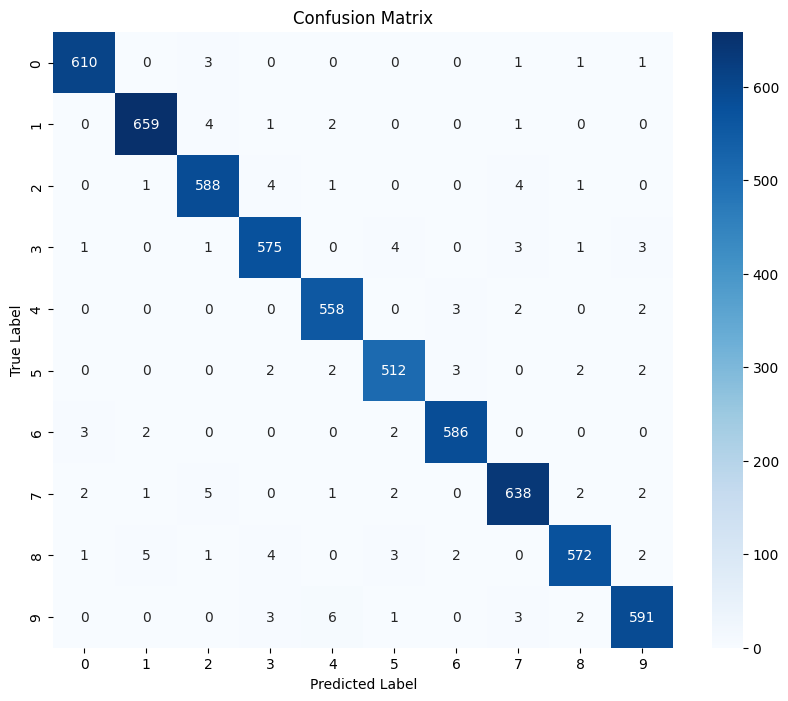


Model saved as 'improved_mnist_model.pth'


In [7]:
def main():
    # Configuration
    CONFIG = {
        'file_path': r"D:\wids '23\Winter-Projects-of-Machine-Learning\MNIST_data.pkl",
        'batch_size': 64,
        'num_epochs': 20,
        'learning_rate': 0.001,
        'hidden_sizes': [128, 64, 32],
        'dropout_rate': 0.3,
        'augment_data': True
    }
    
    print("=== Improved MNIST Classification ===")
    print(f"Configuration: {CONFIG}")
    print("=" * 50)
    
    # Load and preprocess data
    X, y, add_noise_func = load_and_preprocess_data(CONFIG['file_path'])
    if X is None:
        return
    
    # Create data loaders
    train_loader, val_loader, test_loader = create_data_loaders(
        X, y, 
        batch_size=CONFIG['batch_size'],
        augment_data=CONFIG['augment_data'],
        add_noise_func=add_noise_func
    )
    
    # Initialize model
    model = ImprovedNet(
        hidden_sizes=CONFIG['hidden_sizes'],
        dropout_rate=CONFIG['dropout_rate']
    )
    
    print(f"\nModel architecture:")
    print(model)
    print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Train model
    print("\nStarting training...")
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, train_loader, val_loader,
        num_epochs=CONFIG['num_epochs'],
        learning_rate=CONFIG['learning_rate']
    )
    
    # Evaluate model
    print("\nEvaluating model...")
    test_accuracy, predictions, targets = evaluate_model(model, test_loader)
    
    # Plot results
    plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)
    plot_confusion_matrix(targets, predictions, class_names=[str(i) for i in range(10)])
    
    # Save model
    torch.save(model.state_dict(), 'improved_mnist_model.pth')
    print("\nModel saved as 'improved_mnist_model.pth'")

if __name__ == "__main__":
    main()